# <div align="center"><b>RNA-seq normalizations</b></div>

Now that we learned some Python basics, let's apply them to normalizing some RNA-seq data.

In [1]:
# Start by importing useful packages
import pandas as pd  # For data manipulation like reading in from files
import numpy as np  # For math type stuff
import seaborn as sns  # For plotting
import matplotlib.pyplot as plt  # For plotting

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# It can also be useful to specify all your paths here so it is clear where things are coming from
# TODO: Make sure this matches the path of your counts file
#path_counts = "~/scratch/feature_counts/hangauer.results.counts"

# Load data
We will start by reading in the file that was output by the featureCounts tool. This file contains the number of reads that were mapped to each gene in the genome across all samples.

In [3]:
# Load counts in using pandas
# Check out the pandas documentation for more info on read_csv
counts = pd.read_csv(path_counts, comment="#", sep="\t", index_col=0)
gene_info = counts.iloc[:, 0:5]  # 
counts = counts.iloc[:, 5:]
counts.columns = [x.split("/")[-1].split(".")[0] for x in counts.columns]
counts.head()

,BT474_Parental_rep_1,BT474_Parental_rep_2,BT474_Persister_rep_1,BT474_Persister_rep_2,BT474_Persister_rep_3
Geneid,,,,,
ENSG00000223972.4,1,0,2,0,1
ENSG00000227232.4,48,58,121,114,151
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0


In [4]:
# Let's rename the columns to be a bit more informative
counts = counts.rename(
    columns=
    {
        counts.columns[0]:"Parental1",
        counts.columns[1]:"Parental2",
        counts.columns[2]:"Persister1",
        counts.columns[3]:"Persister2",
        counts.columns[4]:"Persister3"
    }
)
counts.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,1,0,2,0,1
ENSG00000227232.4,48,58,121,114,151
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0


# Normalize using RPKM

We will next normalize the data using the RPKM method. This method normalizes the read counts by the length of the gene and the total number of reads in the sample.

When you have an operation you want to be able to apply multiple times, it is a good idea to write a function. Let's write a Python function that takes in the read counts and gene lengths and returns the RPKM values.

In [5]:
def normalize_rpkm(counts_matrix, gene_lengths):
    """
    Normalize an RNA-seq counts matrix using Reads Per Kilobase of transcript per Million mapped reads (RPKM).
    
    RPKM (Reads Per Kilobase of transcript per Million mapped reads) and FPKM (Fragments Per Kilobase 
    of transcript per Million mapped reads) normalize for both the length of the gene and the total 
    number of reads (i.e., the library size), making expression level comparisons between genes 
    in the same sample possible.
    
    Pros:
    - Widely used and established/incorporated in several software tools.
    - Makes it possible to compare gene expression levels within the same sample and between different samples.
    
    Cons:
    - Assumes that the total number of reads is the same across all samples, which isn't always accurate, 
      particularly when comparing different conditions or tissues.
    - Can be biased by highly expressed genes or transcripts, making it less reliable for datasets 
      with a high level of expression variation.
    - Like TPM, it cannot be used for differential expression analysis.
    
    Parameters:
    counts_matrix (pd.DataFrame): A pandas DataFrame containing raw read counts 
                                  with rows as genes and columns as samples.
    gene_lengths (pd.Series): A pandas Series containing the lengths of genes in kilobases.
                              The index should match the row index of the counts_matrix.
    
    Returns:
    pd.DataFrame: A pandas DataFrame with RPKM-normalized expression values.
    """
    
    # Divide by both gene length and total counts, then multiply by 1e9 to get RPKM
    total_reads_per_sample = counts_matrix.sum(axis=0)
    rpm_matrix = counts_matrix.div(total_reads_per_sample, axis=1) * 1e6
    rpkm_matrix = rpm_matrix.div(gene_lengths, axis=0) * 1e3
    
    # The above calculation is equivalent to the following:
    #rpkm_matrix = counts_matrix.div(gene_lengths, axis=0).div(counts_matrix.sum(axis=0), axis=1) * 1e9
    
    return rpkm_matrix

We can see that the above function has several features:
 - First is the `def` keyword, which is used to define a function. 
 - Next is the function name, which is `normalize rpkm`. 
 - This is followed by the arguments that the function takes in, which are `read_counts` and `gene_lengths`. 
 - The function then calculates the total number of reads in the sample and the RPKM values for each gene. 
 - Finally, the function returns the RPKM values.

In [6]:
# Get gene lengths by slicing the columns of the gene_info DataFrame
gene_lengths = gene_info["Length"]
gene_lengths.head()

Geneid
ENSG00000223972.4    1756
ENSG00000227232.4    2073
ENSG00000243485.2    1021
ENSG00000237613.2    1219
ENSG00000268020.2     947
Name: Length, dtype: int64

In [7]:
# Normalize counts using our function
rpkm = normalize_rpkm(counts, gene_lengths)
rpkm.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,0.004917,0.000000,0.010690,0.000000,0.005309
ENSG00000227232.4,0.199913,0.241892,0.547842,0.472673,0.679085
ENSG00000243485.2,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000


# Data visualization
It can be useful to get a sense of what the data looks like after normalization. We can use the `matplotlib` and `seaborn` libraries to generate some useful plots.

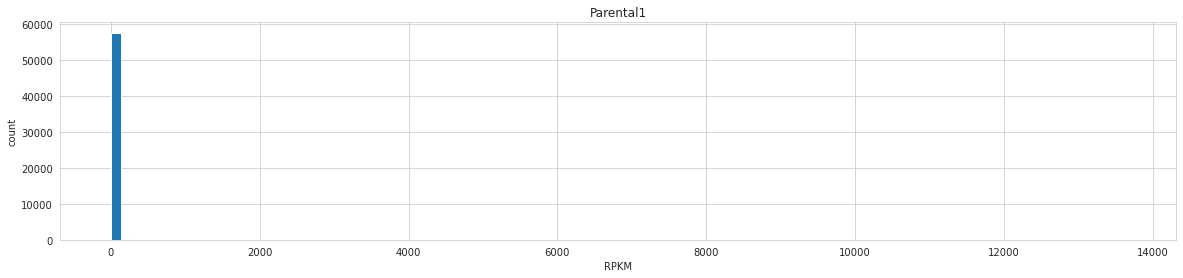

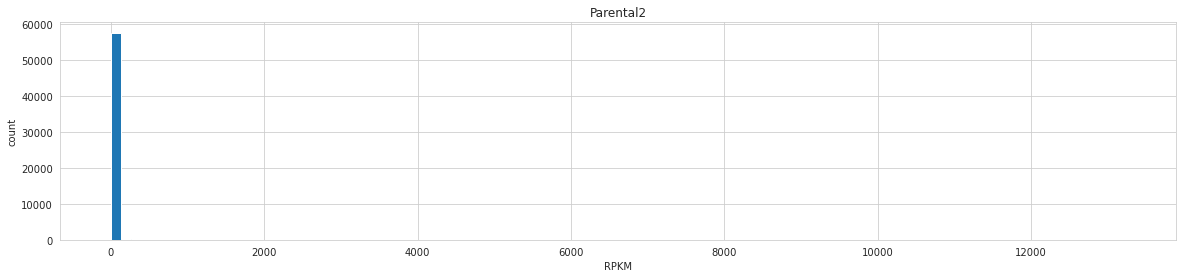

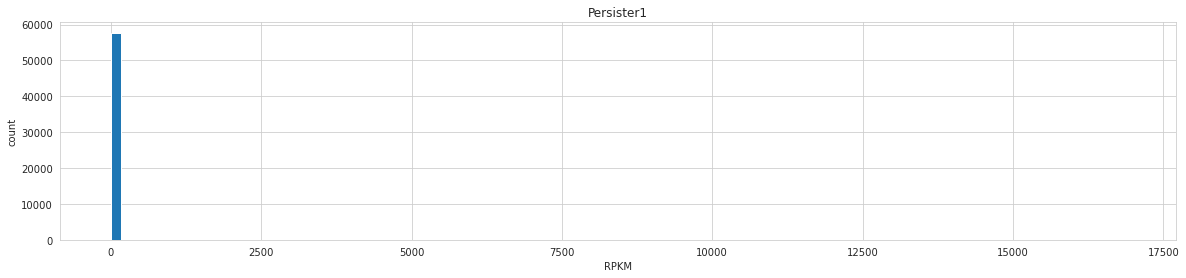

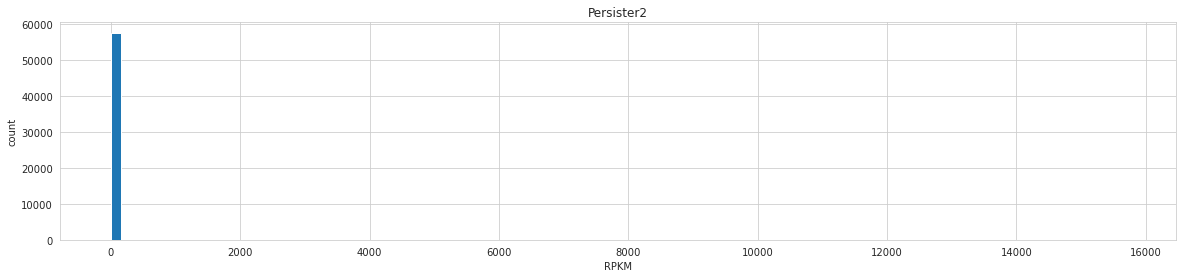

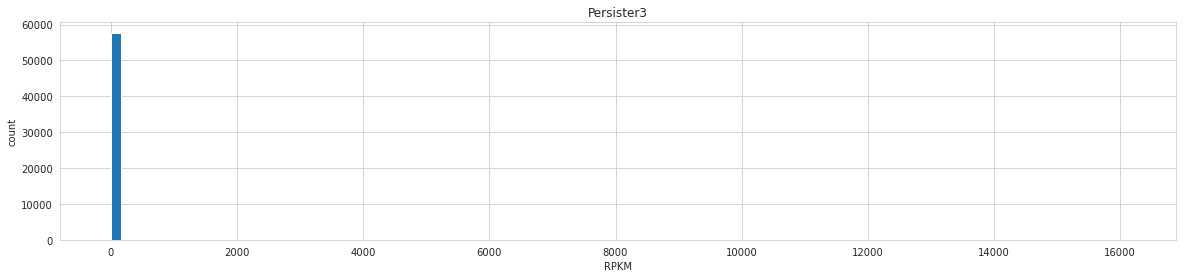

In [14]:
# Let's look at a histogram of the rpkm values for each sample.
sns.set_style("whitegrid")
for i in rpkm.columns:
    plt.figure(figsize=(20,4))
    plt.hist(rpkm[i], bins=100)
    plt.xlabel("RPKM")
    plt.ylabel("count")
    plt.title(i)

Just using RPKM is not very informative because most of our genes are not expressed in each sample. We will remedy this by first removing genes that are very lowly expressed across all samples.

In [15]:
# To get rid of a lot of noise, we are going to drop rows that have RPKM less than 4
rpkm_filtered = rpkm.loc[rpkm.sum(axis=1) > 4]
print(rpkm_filtered.shape)
rpkm_filtered.head()

(13401, 5)


,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000225972.1,3.620597,3.881196,2.144593,2.472273,2.205394
ENSG00000225630.1,2.100544,2.004043,1.726115,1.646589,1.634169
ENSG00000237973.1,26.729319,23.712198,39.446914,42.240664,36.662837
ENSG00000229344.1,8.279268,7.821551,10.500480,11.203997,9.582527
ENSG00000240409.1,1.835189,1.628870,1.360254,1.619384,1.531281


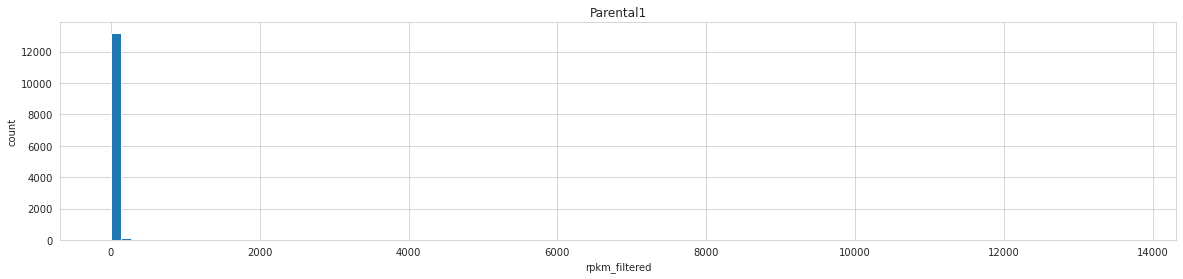

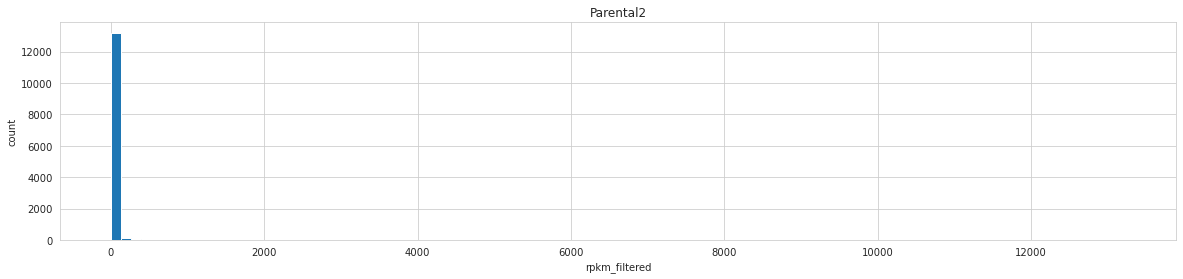

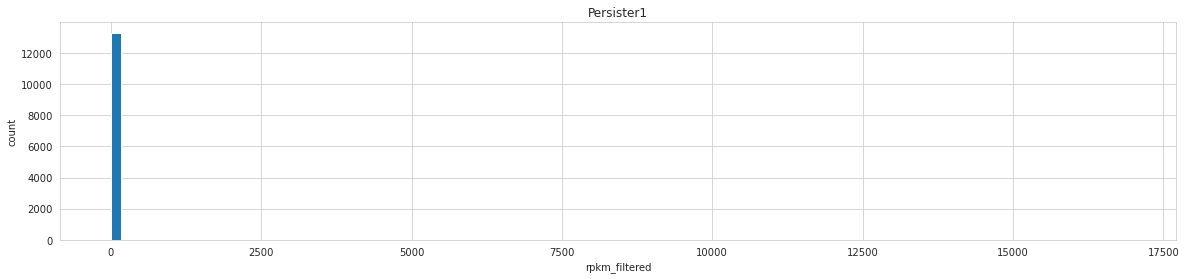

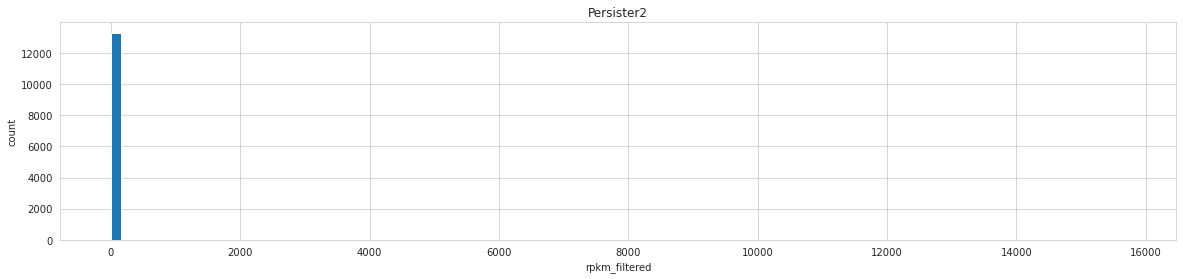

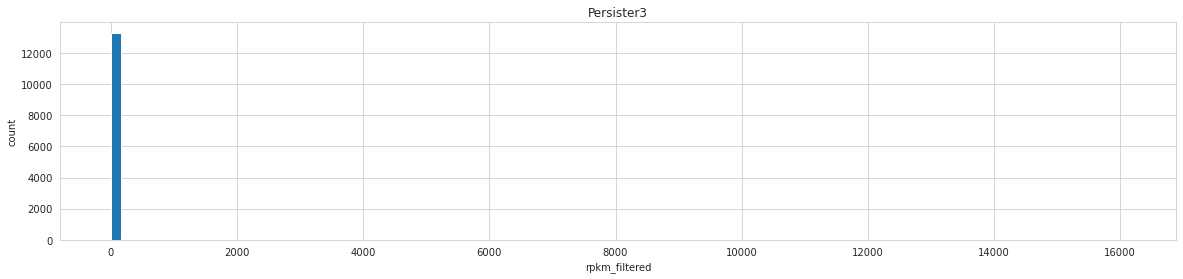

In [16]:
# Let's look at a histogram of the rpkm_filtered values for each sample.
sns.set_style("whitegrid")
for i in rpkm_filtered.columns:
    plt.figure(figsize=(20,4))
    plt.hist(rpkm_filtered[i], bins=100)
    plt.xlabel("rpkm_filtered")
    plt.ylabel("count")
    plt.title(i)

Hmm, we still only see a single bar. This is because we have a few genes that are very highly expressed, with most genes being lowly expressed. We can remedy this by taking the log of the RPKM values.

In [14]:
# Now let's take the log2RPKM. We will include a pseudocount to prevent inf values (i.e. log 0 == -inf /or undefined..)
rpkm_filtered +=1
rpkm_log2 = np.log2(rpkm_filtered)
print(rpkm_log2.shape)
rpkm_log2.head()

(13401, 5)


,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000225972.1,2.208079,2.287235,1.652873,1.795880,1.680502
ENSG00000225630.1,1.632521,1.586905,1.446846,1.404134,1.397348
ENSG00000237973.1,4.793340,4.627151,5.337958,5.434317,5.235070
ENSG00000229344.1,3.214011,3.141032,3.523622,3.609282,3.403612
ENSG00000240409.1,1.503445,1.394443,1.238942,1.389228,1.339868


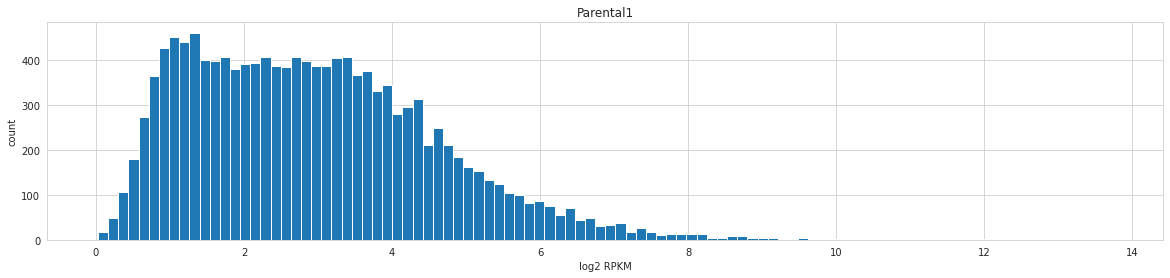

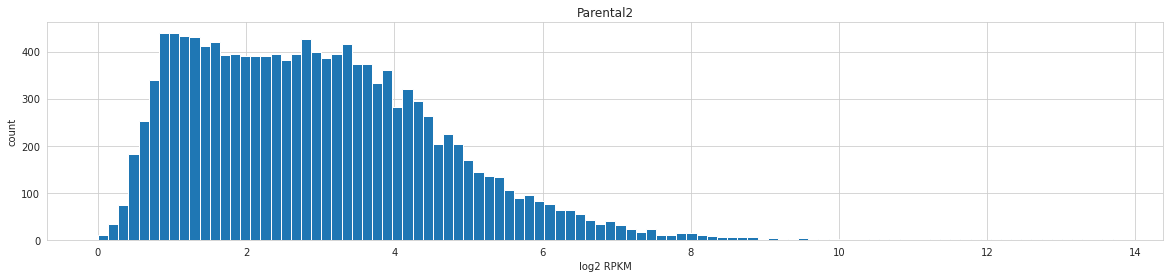

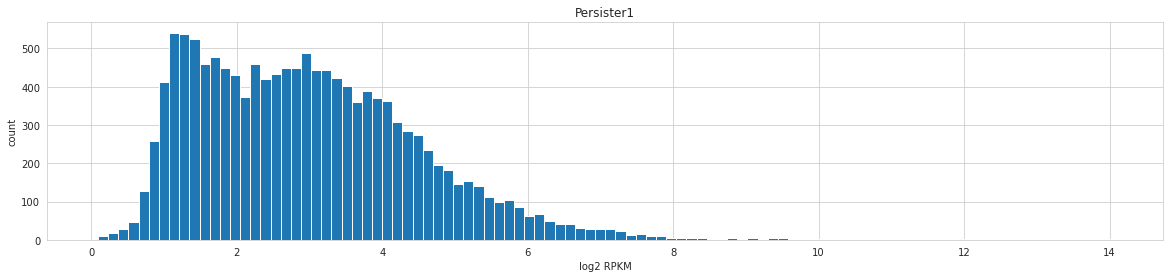

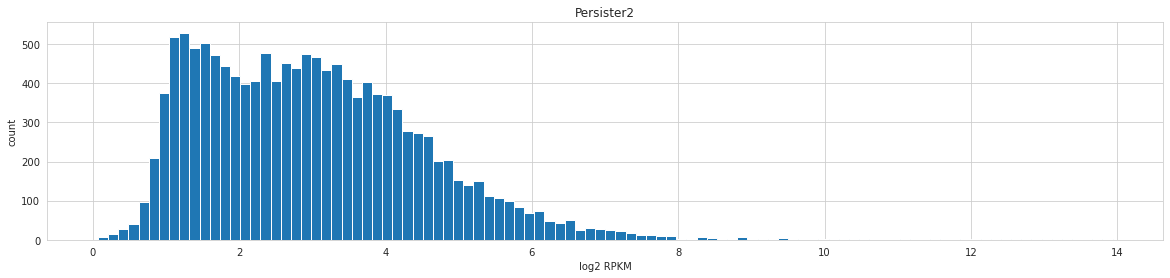

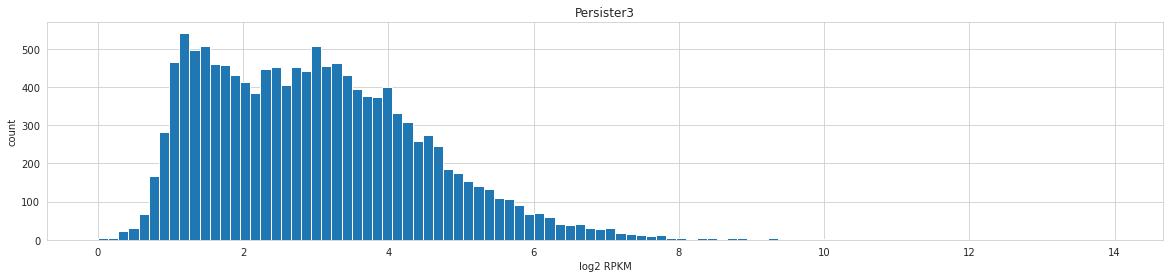

In [15]:
sns.set_style("whitegrid")
for i in rpkm_log2.columns:
    plt.figure(figsize=(20,4))
    plt.hist(rpkm_log2[i], bins=100)
    plt.xlabel("log2 RPKM")
    plt.ylabel("count")
    plt.title(i)

We can see that the the distributions of gene expression values are very similar across samples. This is a good sign that our normalization is working well! Now we just need to hope that we can detect differences in individual genes between samples!

# Clustering

A quick way to check for differences between samples is to cluster the samples based on the gene expression values. We can use the `seaborn` library to both perform the clustering and visualize the results in one function!

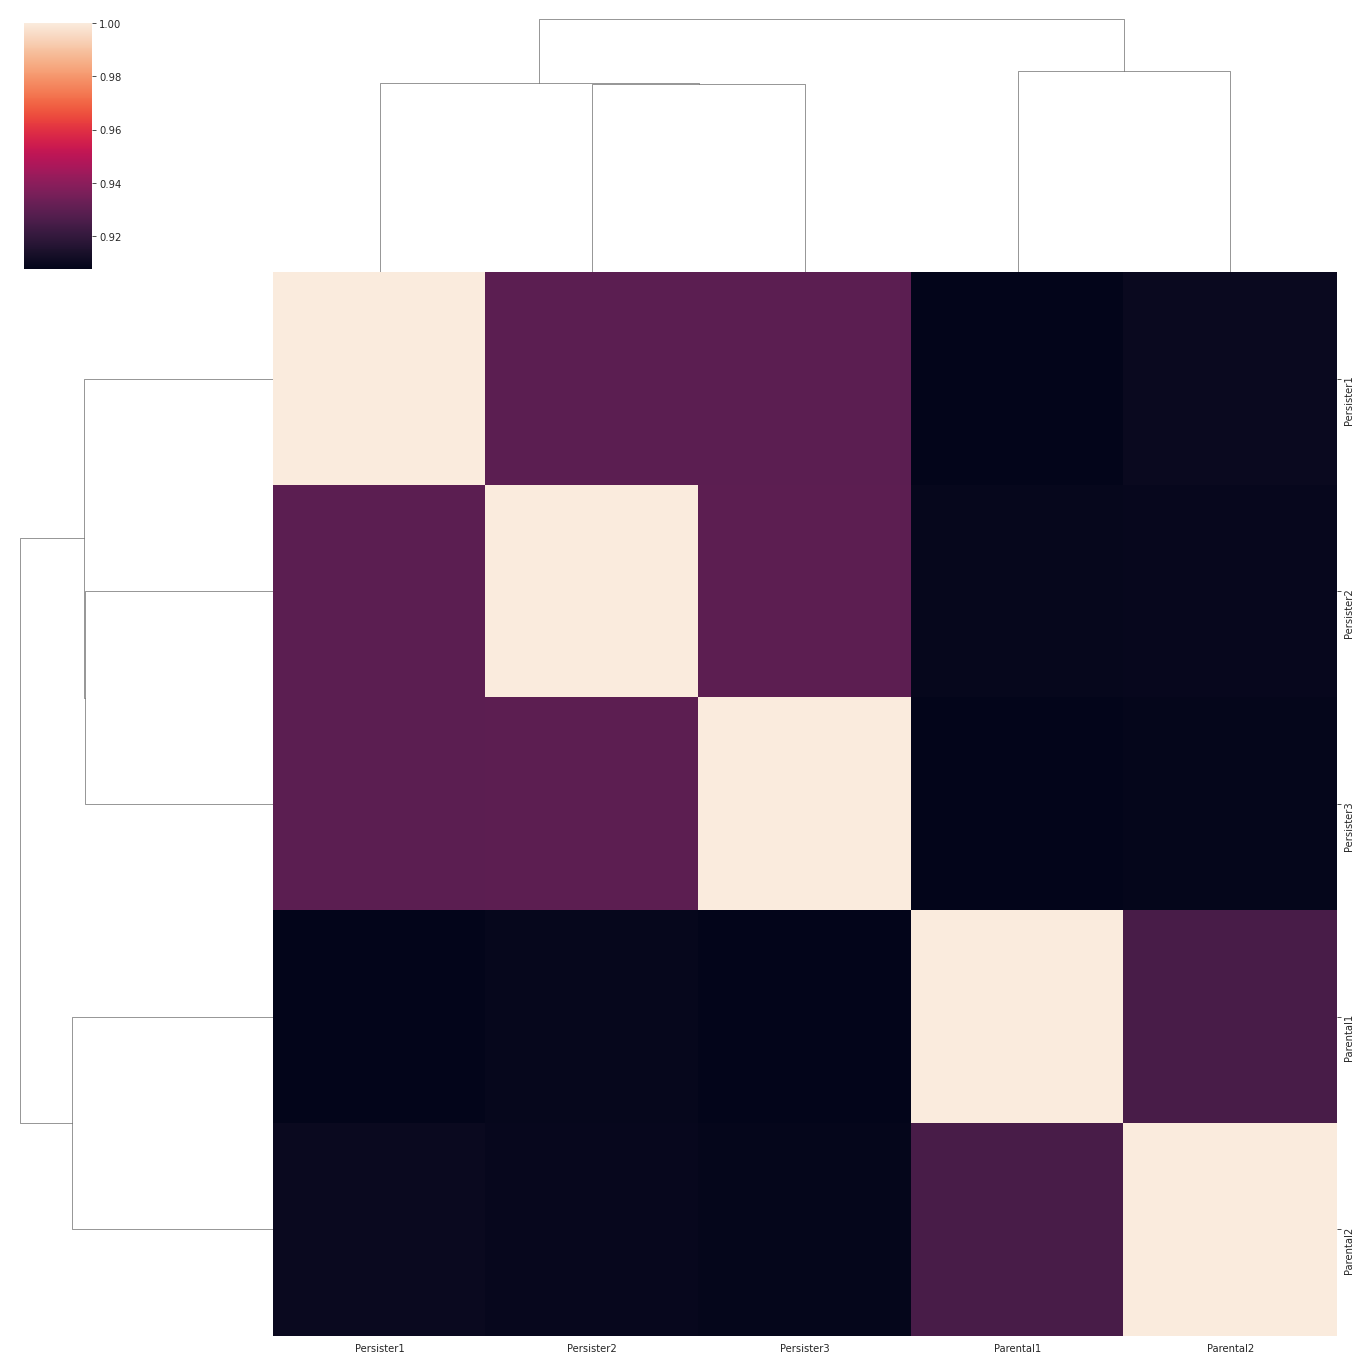

In [16]:
sns.clustermap(rpkm.corr(method='spearman'), figsize = (19,19))

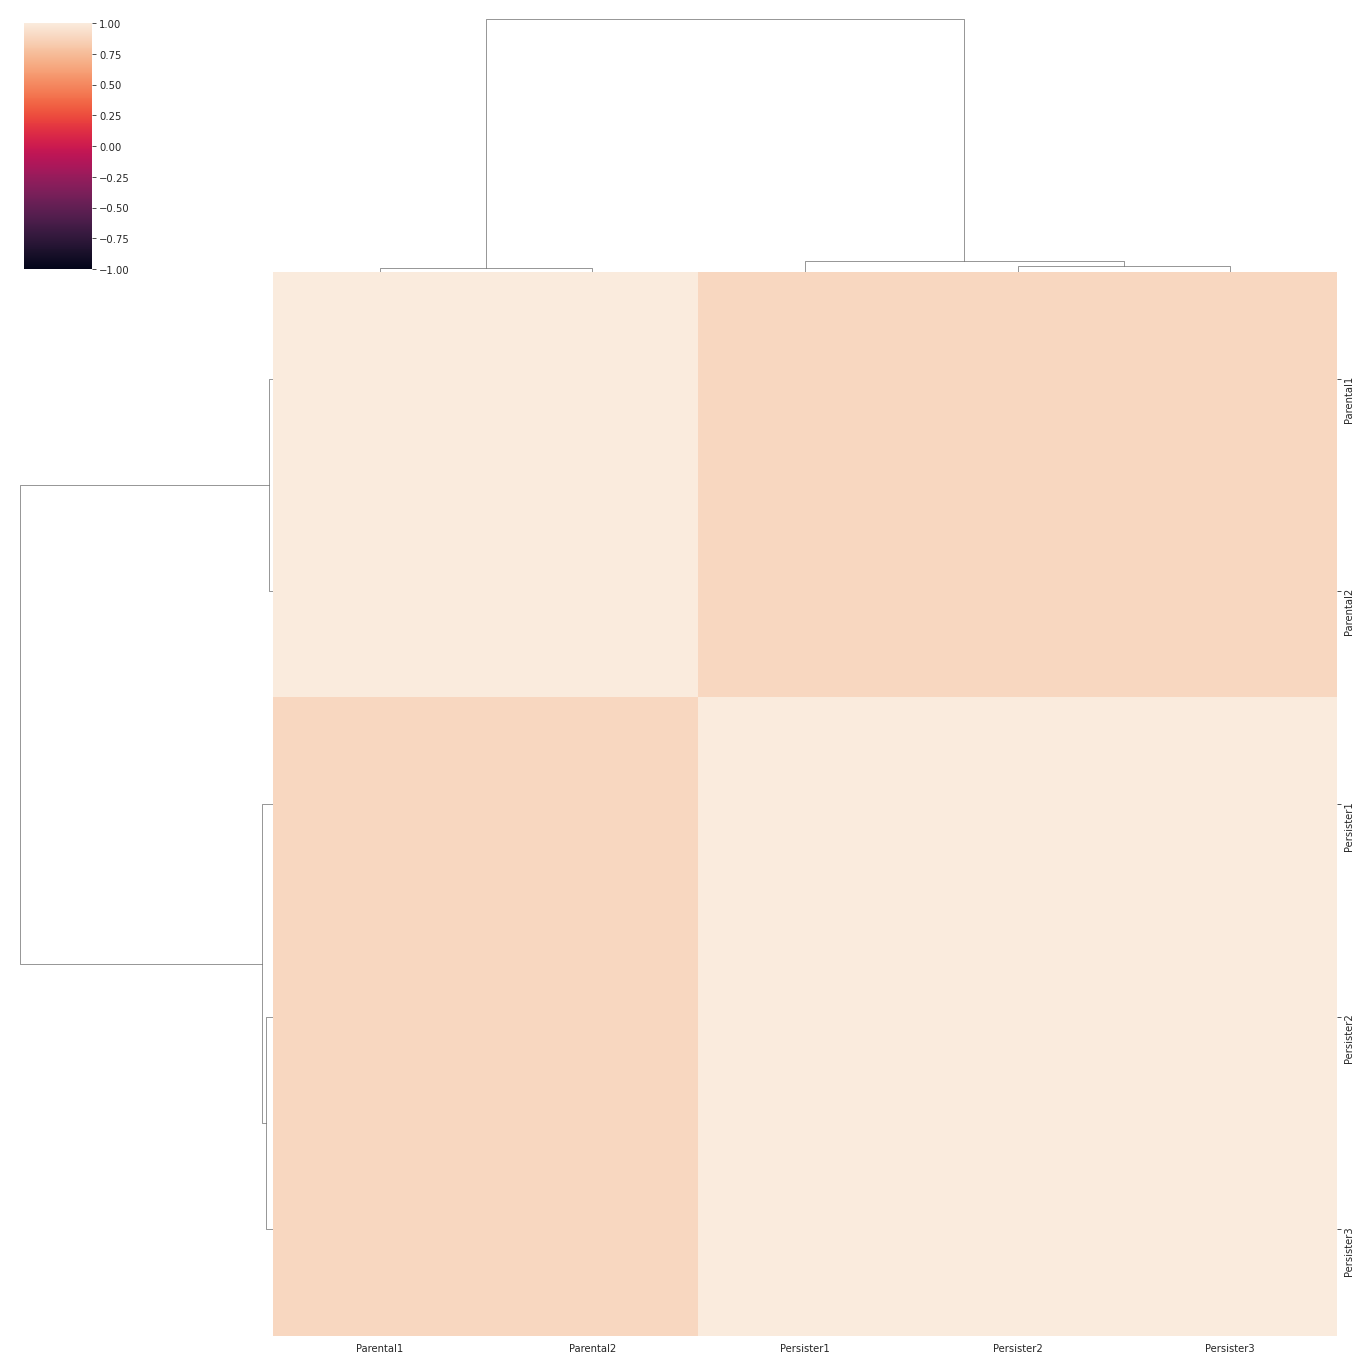

In [17]:
sns.clustermap(rpkm_filtered.corr(method='spearman'),vmin=-1,vmax=1, figsize = (19,19))

We can see that our parental cells form a different cluster from our persister cells. This is what we expected and is a good sign that we should be able to detect differences in gene expression between the two groups!

# DONE!

---